# Introduction
- nb38のノートブックを改良
- 改良点
    - one hot encoding
    - 対数変換
    - nan のある特徴量を削除

# Import everything I need :)

In [1]:
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightgbm as lgb
from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 41
isSmallSet = False
length = 10000
is_cuda = torch.cuda.is_available()
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(3))

True


In [3]:
pd.set_option('display.max_columns', 200)
warnings.filterwarnings('ignore')

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
# fc_train
path = file_path + 'nb29_fc_train_feature.csv'
if isSmallSet:
    fc_train = pd.read_csv(path)[:length]
else:
    fc_train = pd.read_csv(path)

In [9]:
# fc_test
path = file_path + 'nb29_fc_test_feature.csv'
if isSmallSet:
    fc_test = pd.read_csv(path)[:length]
else:
    fc_test = pd.read_csv(path)

In [10]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [11]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [12]:
# ob charge train
path = file_path + 'train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_train = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_train = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [13]:
# ob charge test
path = file_path + 'test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_test = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_test = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [14]:
len(test), len(fc_test)

(2505542, 2505542)

In [15]:
len(train), len(fc_train)

(4658147, 4658147)

In [16]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [17]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [18]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

In [19]:
type_train = train['type']
type_test  = test['type']

**dist-interact**

**basic**

In [20]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df


# structure and ob_charges
ob_charge = pd.concat([ob_charge_train, ob_charge_test])
merge = pd.merge(ob_charge, structures, how='left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
for atom_idx in [0,1]:
    train = map_atom_info(train, merge, atom_idx)
    test  = map_atom_info(test,  merge, atom_idx)
    
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}',
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}',})
    test = test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}', 
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}'})
#     test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
#                                         'x': f'x_{atom_idx}',
#                                         'y': f'y_{atom_idx}',
#                                         'z': f'z_{atom_idx}'})

# ob_charges
# train = map_atom_info(train, ob_charge_train, 0)
# test  = map_atom_info(test,  ob_charge_test,  0)
# train = map_atom_info(train, ob_charge_train, 1)
# test  = map_atom_info(test,  ob_charge_test,  1)

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [21]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df

distances

In [22]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

distance 統計量

In [23]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    return df

angle features

In [24]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [25]:
%%time

print('add fc')
print(len(train), len(test))
train['fc'] = fc_train.values
test['fc']  = fc_test.values

print('type0')
print(len(train), len(test))
train = create_type0(train)
test  = create_type0(test)

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)

print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

add fc
4658147 2505542
type0
4658147 2505542
distances
4658147 2505542
create_featueres
4658147 2505542
create_closest
4658147 2505542
add_cos_features
4658154 2505542
CPU times: user 1min 35s, sys: 2min 11s, total: 3min 47s
Wall time: 3min 47s


---
<br>
<br>
<br>
nanがある特徴量を削除

In [26]:
# nan がある特徴量
drop_feats = train.columns[train.isnull().sum(axis=0) != 0].values
drop_feats

array(['molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean_div',
       'molecule_atom_index_0_y_1_std', 'molecule_atom_index_0_z_1_std',
       'molecule_atom_index_0_dist_std',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div',
       'molecule_atom_index_1_dist_std',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_std',
       'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std',
       'molecule_type_0_dist_std_diff', 'molecule_type_dist_std',
       'molecule_type_dist_std_diff'], dtype=object)

In [27]:
train = train.drop(drop_feats, axis=1)
test  = test.drop(drop_feats, axis=1)

assert sum(train.isnull().sum(axis=0))==0, f'train に nan があります。'
assert sum(test.isnull().sum(axis=0))==0,  f'test に nan があります。'

<br>
<br>
<br>
カテゴリカル特徴量 と 数値特徴量

In [28]:
# inf がある特徴量を削除
df = train
for feat in progress_bar(df.columns):
    logi = (df[feat]==np.inf)
    if sum(logi) >= 1:
        print(feat)

In [29]:
# int 型の列挙
for feat in train.columns:
    if train[feat].dtypes == np.dtype('int64'):
        print(feat)

id
atom_index_0
atom_index_1
molecule_couples
atom_0_couples_count
atom_1_couples_count
atom_index_closest_0
atom_index_closest_1


In [30]:
cat_cols = ['atom_1','type_0','type']
num_cols = list(set(train.columns) - set(cat_cols) - set(["scalar_coupling_constant", 'molecule_name', 'id', 'atom_0',
                                                          'atom_index_closest_0', 'atom_index_closest_1']))
print(f'カテゴリカル: {cat_cols}')
print(f'数値:        {num_cols}')

カテゴリカル: ['atom_1', 'type_0', 'type']
数値:        ['atom_index_1', 'eem2015bn_0', 'molecule_atom_index_0_y_1_max_diff', 'eem2015bm_1', 'molecule_atom_index_1_dist_mean_div', 'x_closest_1', 'molecule_type_dist_min', 'molecule_dist_max', 'molecule_atom_1_dist_mean', 'molecule_atom_index_1_dist_max_diff', 'molecule_atom_index_0_y_1_mean_diff', 'cos_0', 'molecule_atom_index_0_y_1_max', 'x_0', 'dist_y', 'molecule_atom_1_dist_min_diff', 'molecule_atom_index_1_dist_mean_diff', 'atom_index_0', 'cos_0_1', 'dist_x', 'z_closest_1', 'cos_1', 'qeq_1', 'molecule_atom_index_1_dist_min_diff', 'atom_1_couples_count', 'eem2015hm_0', 'y_1', 'distance_0', 'eem2015ha_0', 'molecule_couples', 'eem2015ha_1', 'eem2015ba_0', 'eem2015hn_0', 'atom_0_couples_count', 'mmff94_1', 'molecule_atom_index_1_dist_mean', 'y_0', 'eem2015bm_0', 'fc', 'z_closest_0', 'z_0', 'molecule_atom_index_0_y_1_mean', 'eem2015hm_1', 'qeq_0', 'qtpie_0', 'dist', 'molecule_dist_min', 'y_closest_1', 'eem_0', 'molecule_dist_mean', 'x_closest_0'

<br>
<br>
one hot encoding

In [31]:
train = pd.get_dummies(train, columns=cat_cols)
test  = pd.get_dummies(test,  columns=cat_cols)

In [32]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,x_1,y_1,z_1,fc,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_1_C,atom_1_H,atom_1_N,type_0_1,type_0_2,type_0_3,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN
0,0,dsgdb9nsd_000001,1,0,84.8076,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.002150,-0.006031,0.001976,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,-0.012698,1.085804,0.008001,83.534069,1.091953,0.000220,1.192105,0.000036,10,1.506668,1.091946,1.783158,4,4,1.358754,0.272949,1.463751,0.377947,1.610344,0.518391,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,1.091950,-0.000003,0.999997,1.091953,0.000000,1.000000,1.091946,-0.000007,0.999994,1.091950,1.091946,-0.000007,0.999994,1.091950,-0.000003,0.999997,1.091953,1.091946,0,-0.012698,1.085804,0.008001,3,-0.540815,1.447527,-0.876644,1.091953,1.091946,0.333335,-1.000000,-0.333335,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,1,2,-11.2570,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.002150,-0.006031,0.001976,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,1.011731,1.463751,0.000277,-11.692044,1.783120,1.019253,2.160261,0.000003,10,1.506668,1.091946,1.783158,4,1,1.358754,-0.104998,1.463751,0.000000,1.610344,-0.172776,0.903105,1.783157,0.000037,1.000021,1.091953,-0.691167,0.612383,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,1.783146,1.783120,0.000000,1.000000,1.783146,0.000027,1.000015,1.783158,1.783120,0,-0.012698,1.085804,0.008001,0,-0.012698,1.085804,0.008001,1.091953,1.091952,-0.333287,-0.816483,0.816482,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,2,dsgdb9nsd_000001,1,3,-11.2548,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.002150,-0.006031,0.001976,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,-0.540815,1.447527,-0.876644,-11.431845,1.783147,0.294812,2.112831,0.771973,10,1.506668,1.091946,1.783158,4,2,1.358754,-0.088773,1.463751,0.016225,1.610344,-0.172803,0.903091,1.783157,0.000009,1.000005,1.091953,-0.691194,0.612374,1.783153,0.000005,1.000003,1.783158,0.000010,1.000006,1.783147,0.000000,1.000000,1.783146,1.783120,-0.000028,0.999984,1.783146,-0.000001,0.999999,1.783158,1.783120,0,-0.012698,1.085804,0.008001,0,-0.

<br>
<br>
<br>
数値特徴量を対数変換

In [33]:
# 負の値は変換できないので、平行移動する
for feat in train.columns:
    if feat in num_cols:
        if train[feat].min()<=0:
            train[feat] = train[feat].values + np.abs(train[feat].min())
            test[feat]  = test[feat].values + np.abs(train[feat].min())  # <---ここtrain分ずらすということでいいのかね

        # 対数変換
        train[feat] = np.log10(train[feat].values + 1e-10)
        test[feat]  = np.log10(test[feat].values + 1e-10)

In [34]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,x_1,y_1,z_1,fc,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_1_C,atom_1_H,atom_1_N,type_0_1,type_0_2,type_0_3,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN
0,0,dsgdb9nsd_000001,4.342945e-11,-10.000000,84.8076,-0.792820,-10.0,-1.335898,0.139280,0.230709,-0.627142,-0.691961,-0.707225,-0.573625,-0.695545,-0.672002,H,0.965533,0.977181,0.960791,-0.413872,0.047664,-0.215354,0.996534,0.554950,0.240274,-0.418191,-0.167052,0.182812,0.573365,-0.297706,0.964834,1.014529,0.944341,2.054438,0.038204,-3.656632,0.076314,-4.440103,1.0,0.178017,0.038201,0.25119,0.602060,6.020600e-01,0.938064,0.544839,0.903352,-0.422569,0.206919,0.305279,0.168715,0.25119,-0.160394,2.129855e-01,0.038204,0.452419,4.342945e-11,0.038203,0.293799,-1.356194e-06,0.038204,-10.000000,4.342945e-11,0.038201,0.453641,-2.656943e-06,0.038203,0.038201,0.454012,-2.656943e-06,0.038203,-0.012575,-1.356194e-06,0.038204,0.038201,0,0.937777,0.97856,0.926738,3,0.939223,1.039084,0.898313,0.038204,0.038201,0.124939,-9.999996,-0.176092,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,4.342945e-11,0.301030,-11.2570,-0.792820,-10.0,-1.335898,0.139280,0.230709,-0.627142,-0.691961,-0.707225,-0.573625,-0.695545,-0.672002,H,0.965533,0.977181,0.960791,0.076004,0.047664,-0.151174,0.767645,0.872509,0.235690,0.145523,0.220596,0.206172,0.676892,0.195322,1.010581,1.030120,0.943960,1.258357,0.251181,0.008282,0.334506,-5.539319,1.0,0.178017,0.038201,0.25119,0.602060,4.342945e-11,0.938064,0.495305,0.903352,-10.000000,0.206919,0.123360,-0.044262,0.25119,-4.432628,8.994404e-06,0.038204,0.331013,-2.129765e-01,0.251181,0.293800,4.342945e-11,0.251181,-10.000000,4.342945e-11,0.251181,0.453642,4.342945e-11,0.251187,0.251181,0.454013,4.342945e-11,0.251187,-0.012562,6.467617e-06,0.251190,0.251181,0,0.937777,0.97856,0.926738,0,0.964834,1.024484,0.944341,0.038204,0.038203,-0.176061,-0.736323,0.259231,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,2,dsgdb9nsd_000001,4.342945e-11,0.477121,-11.2548,-0.792820,-10.0,-1.335898,0.139280,0.230709,-0.627142,-0.691961,-0.707225,-0.573625,-0.695545,-0.672002,H,0.965533,0.977181,0.960791,0.076005,0.047664,-0.151174,0.767644,0.872510,0.235690,0.145524,0.220597,0.206172,0.676892,0.195323,0.939223,1.029462,0.898313,1.264546,0.251187,-0.530456,0.324865,-0.112398,1.0,0.178017,0.038201,0.25119,0.602060,3.010300e-01,0.938064,0.497551,0.903352,-1.789827,0.206919,0.123351,-0.044269,0.25119,-5.036730,2.238047e-06,0.038204,0.331008,-2.129833e

<br>
<br>
<br>
標準化

In [35]:
print('scaling numerical columns')
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

scaling numerical columns


---
**show features**

In [36]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,x_1,y_1,z_1,fc,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_1_C,atom_1_H,atom_1_N,type_0_1,type_0_2,type_0_3,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN
0,0,dsgdb9nsd_000001,-10.366342,-3.634371,84.8076,0.132197,-0.641577,-1.544775,-1.711264,1.497592,-0.858051,-0.478454,-0.04115,-0.74993,-0.567106,0.022058,H,0.040094,0.208871,0.057147,-2.978409,0.01909,-0.388349,2.022274,-3.219651,-0.057037,-2.783360,-3.084524,-0.256065,-2.069794,-3.648768,0.009961,0.846013,0.017581,2.029830,-1.947376,-3.602152,0.284730,-4.058252,-4.962834,-10.755326,0.836253,-24.443857,-1.550636,-0.364651,1.110265,0.386544,0.378266,0.307823,-5.354433,0.762375,0.925882,-7.977528,0.430037,0.280687,-0.119254,1.297346,1.886994,-4.437702,0.163612,-0.144076,-4.900068,-1.691695,-0.863684,-0.790310,0.853393,1.022826,-10.986149,-0.497168,1.104925,1.455048,-1.979710,0.105752,-0.034364,-1.927202,-2.014912,0,0.007718,0.743897,0.025785,3,-0.267123,0.903250,-0.535574,-0.119254,-0.492603,0.420598,-2.204558,-0.181178,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,-10.366342,0.138106,-11.2570,0.132197,-0.641577,-1.544775,-1.711264,1.497592,-0.858051,-0.478454,-0.04115,-0.74993,-0.567106,0.022058,H,0.040094,0.208871,0.057147,0.792022,0.01909,0.242431,-0.594770,0.723779,-0.094068,0.778869,0.861228,-0.035810,0.850428,0.970773,0.630292,1.019326,0.011655,-1.372183,-0.605219,0.228630,0.533133,-5.124509,-4.962834,-10.755326,0.836253,-24.443857,-1.550636,-2.496121,1.110265,0.055106,0.378266,-2.209320,-5.354433,0.030146,-0.444257,-7.977528,-0.713724,-1.060237,-0.119254,0.791084,0.567074,-1.564928,0.163617,-0.144066,-2.556100,-1.691695,-0.863684,0.655358,0.853397,1.022840,-3.977383,1.712958,1.104929,1.455063,-0.619733,0.105886,-0.034102,-0.731831,-0.426832,0,0.007718,0.743897,0.025785,0,0.033576,0.757334,0.052408,-0.119254,-0.492586,0.320023,0.424836,0.815873,0,1,0,0,1,0,0,0,0,1,0,0,0,0


In [37]:
print(len(test.columns))
print(test.columns)

102
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'eem_0',
       'mmff94_0', 'gasteiger_0', 'qeq_0', 'qtpie_0', 'eem2015ha_0',
       ...
       'type_0_2', 'type_0_3', 'type_1JHC', 'type_1JHN', 'type_2JHC',
       'type_2JHH', 'type_2JHN', 'type_3JHC', 'type_3JHH', 'type_3JHN'],
      dtype='object', length=102)


# create train, test data

In [38]:
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()

assert len(X.columns) == len(X_test.columns), f'X と X_test のサイズが違います X: {len(X.columns)}, X_test: {len(X_test.columns)}'

Mem. usage decreased to 3180.73 Mb (2.5% reduction)
Mem. usage decreased to 1691.75 Mb (2.5% reduction)


In [39]:
del train, test

In [40]:
gc.collect()

35

# Training model

**params**

In [41]:
# ----- set params -----
n_folds = 2
# batch_size = 200
batch_size = int(1024 * 5 * 8)
train_epochs = 50
VERBOSE = 10
n_feats =  X.shape[1]
# -----------------------

In [42]:
folds = KFold(n_splits=n_folds, shuffle=True)

In [43]:
# sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# analysis
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in progress_bar([i * 0.01 for i in range(100)]):
        score = accuracy_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'accuracy_score': best_score}
    return search_result

# Model
class Model(nn.Module):
    def __init__(self, in_features, out_features, p=0.4, bias=True):
        super(Model, self).__init__()
        self.fc0 = nn.Linear(in_features, 100, bias)
        self.bn0 = nn.BatchNorm1d(100)
        
        self.fc1 = nn.Linear(100, 512, bias)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 1024, bias)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 1024, bias)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.fc4 = nn.Linear(1024, 512, bias)
        self.bn4 = nn.BatchNorm1d(512)
        
        self.fc5 = nn.Linear(512, 512, bias)
        self.bn5 = nn.BatchNorm1d(512)
        
        self.fc6 = nn.Linear(512, 256, bias)
        self.bn6 = nn.BatchNorm1d(256)
        
        self.fc7 = nn.Linear(256, 256, bias)
        self.bn7 = nn.BatchNorm1d(256)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc9 = nn.Linear(128, 64, bias)
        self.bn9 = nn.BatchNorm1d(64)
        
        self.fc10= nn.Linear(64, out_features)
        
        
        # その他
        self.drop = nn.Dropout(p)
        self.leaky_relu = nn.LeakyReLU(0.05)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.bn0(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc7(x)
        x = self.bn7(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc8(x)
        x = self.bn8(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc9(x)
        x = self.bn9(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc10(x)
        return x
    

In [44]:
%%time
# Kfold のループ部分
train_preds = np.zeros((len(X)))
test_preds  = np.zeros((len(X_test)))
for i, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

    # X, y, X_val, y_val をテンソル化(PyTorch で扱える形に変換)し、 .cuda() (GPUで計算するために特徴量を GPU に渡す処理)をする。
    X_train_fold = torch.tensor(X.iloc[train_idx, :].values, dtype=torch.float32)
    X_val_fold   = torch.tensor(X.iloc[valid_idx, :].values, dtype=torch.float32)
    X_test_      = torch.tensor(X_test.iloc[:,:].values, dtype=torch.float32) 
    y_train_fold = torch.tensor(y[train_idx, np.newaxis], dtype=torch.float32)
    y_val_fold   = torch.tensor(y[valid_idx, np.newaxis], dtype=torch.float32)
    
    # model を呼び出し
    model = Model(n_feats, 1)
    
    # gpu 使えるならcudaに渡す
    if is_cuda:
        X_train_fold = X_train_fold.cuda()
        y_train_fold = y_train_fold.cuda()
        X_val_fold   = X_val_fold.cuda()
        y_val_fold   = y_val_fold.cuda()
        model = model.cuda()
        model = nn.DataParallel(model) # make parallel
#         model = nn.DataParallel(model).cuda() # マルチGPU
#         cudnn.benchmark = True
    
    # loss 関数を呼び出す。BCELoss() よりも好まれるらしい。。
#     loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # dataloader で扱える形( = Dataset )にする
    train_ = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
    valid_ = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)
    test_  = torch.utils.data.TensorDataset(X_test_)
    
    # X_train_fold batch_size個, y_train_fold batch_size個ずつを各ループで返す iterater の定義
    train_loader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=True)
    # X_valid_fold batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
    valid_loader = torch.utils.data.DataLoader(valid_, batch_size=batch_size, shuffle=False)
    # X_test batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
    test_loader = torch.utils.data.DataLoader(test_, batch_size=batch_size, shuffle=False)
    
    print('-'*70)
    print(f'- Fold {i + 1}/{n_folds}')
    print(f'Fold {i + 1} started at {time.ctime()}')
    
    # epoch 分のループを回す
    for epoch in range(train_epochs):
        start_time = time.time()
        
        # model を train mode にする
        model.train()
        avg_loss = 0.

        # X_train_fold と y_train_fold を batch_size 個ずつ渡すループ
#         for X_batch, y_batch in progress_bar(train_loader):
        for X_batch, y_batch in train_loader:
            # predict
            y_pred = model.forward(X_batch)
            # loss の計算
            loss = loss_fn(y_pred, y_batch)
#             loss_sum = loss0.item() + loss1.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
        
        if  (epoch+1==1) or ((epoch+1)%VERBOSE==0) or (epoch+1==train_epochs):
            model.eval()
            valid_preds_fold = np.zeros((X_val_fold.size(0)))
            test_preds_fold = np.zeros(len(X_test_))
            avg_val_loss = 0.
            for i, (X_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(X_batch).detach()
                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, train_epochs, avg_loss, avg_val_loss, elapsed_time))

    # X_test_fold を batch_size ずつ渡すループ    
    for i, (X_batch,) in enumerate(test_loader):
        y_pred = model(X_batch).detach()

        # batch_size のリストのリストになっているのを単一階層のリストに変換して、cpuに値を渡し、テンソルから numpy.array()に変換したものを sigmoid 関数に渡す
        test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

    train_preds[valid_idx] = valid_preds_fold

    # 予測値の kfold数で割った値を加える
    test_preds += test_preds_fold / n_folds
    
X['scalar_coupling_constant'] = y
X['type'] = type_train
cv_score = kaggle_metric(X, train_preds)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('\n CV mean score(group log mae): {0:.4f}\n'.format(cv_score))

----------------------------------------------------------------------
- Fold 1/2
Fold 1 started at Tue Aug 13 08:36:21 2019
Epoch 1/50 	 loss=12.5027 	 val_loss=7.9557 	 time=79.57s
Epoch 10/50 	 loss=2.5648 	 val_loss=1.3190 	 time=53.01s
Epoch 20/50 	 loss=2.4337 	 val_loss=1.2935 	 time=51.69s
Epoch 30/50 	 loss=2.3564 	 val_loss=1.5091 	 time=52.08s
Epoch 40/50 	 loss=2.3265 	 val_loss=1.3220 	 time=51.57s
Epoch 50/50 	 loss=2.2722 	 val_loss=1.5318 	 time=53.54s
----------------------------------------------------------------------
- Fold 2/2
Fold 2 started at Tue Aug 13 09:04:10 2019
Epoch 1/50 	 loss=11.4855 	 val_loss=3.8920 	 time=51.95s
Epoch 10/50 	 loss=2.5562 	 val_loss=1.3006 	 time=52.35s
Epoch 20/50 	 loss=2.4204 	 val_loss=1.3112 	 time=52.05s
Epoch 30/50 	 loss=2.3524 	 val_loss=1.5050 	 time=52.39s
Epoch 40/50 	 loss=2.2785 	 val_loss=1.6313 	 time=52.11s
Epoch 50/50 	 loss=2.2563 	 val_loss=1.6708 	 time=52.93s


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [47]:
X['scalar_coupling_constant'] = y
X['type'] = type_train
cv_score = kaggle_metric(X, train_preds)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('\n CV mean score(group log mae): {0:.4f}\n'.format(cv_score))

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [49]:
len(type_train)

4658147

In [50]:
len(train_preds)

4658154

In [51]:
len(X)

4658154

# Save

**submission**

In [46]:
path_submittion = '../output/' + 'nb{}_submission_nn_{:.4f}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

NameError: name 'cv_score' is not defined

In [ ]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
if isSmallSet :
    print('using small set')
else :
    submittion['scalar_coupling_constant'] = test_preds
    submittion.to_csv(path_submittion, index=False)  if not isSmallSet else print('using small set')

---
**result**

In [ ]:
path_oof = '../output/' + 'nb{}_oof_nn_{:.4f}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

In [ ]:
if isSmallSet:
    print('using small set')
else :
    oof = pd.DataFrame({'oof':train_preds})
    oof.to_csv(path_oof, index=False) if not isSmallSet else print('using small set')

# analysis

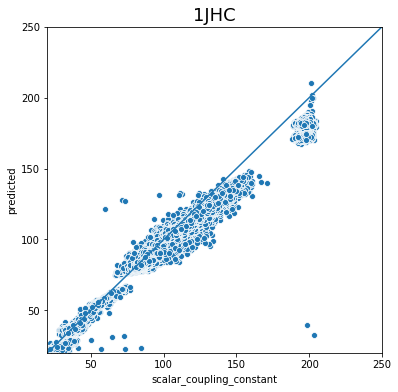

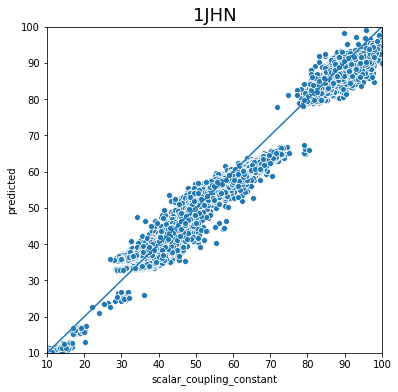

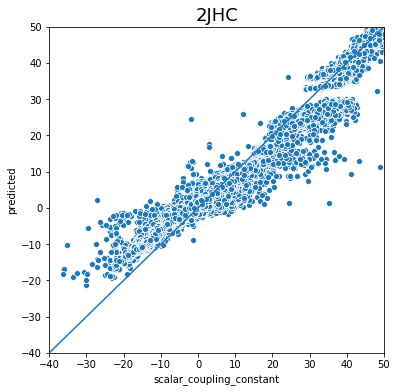

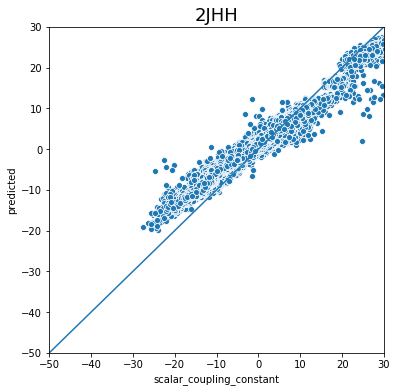

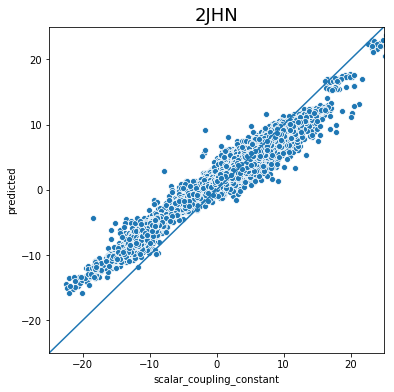

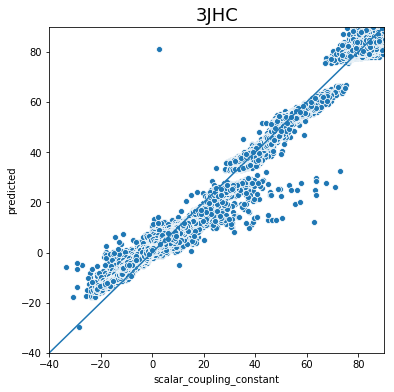

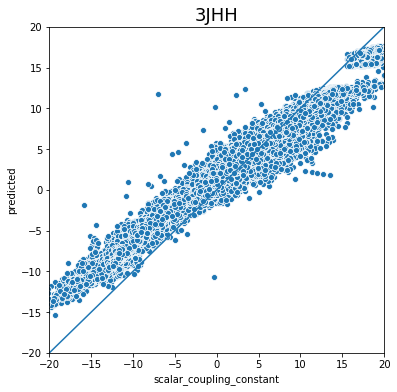

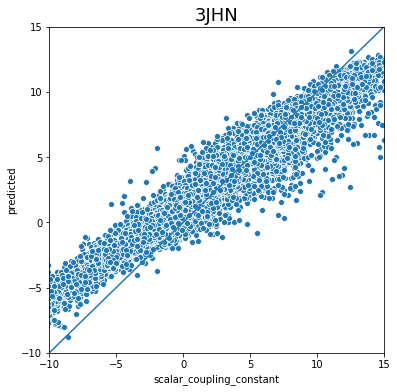

In [52]:
plot_data = pd.DataFrame({'scalar_coupling_constant': y} )
plot_data.index.name = 'id'
plot_data['yhat'] = train_preds
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 20, 250)
plot_oof_preds('1JHN', 10, 100)
plot_oof_preds('2JHC', -40, 50)
plot_oof_preds('2JHH', -50, 30)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -40, 90)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)